# Zero‑Shot классификация изображений маркетплейса: **lifestyle vs catalog** (Qwen‑VL)





В этом блокноте мы попрактикуем применение модели [Qwen 3B VL](https://huggingface.co/docs/transformers/v4.49.0/en/model_doc/qwen2_5_vl)  для изображений.

Посмотрим для каких целей можно использовать, как регулировать выход модели. В финале вы получите полный рабочий пайплайн на маленьком датасете. с вычислением метрик и с возможностью менять промт и прочие настройки, чтобы быстро экспериментировать и подбирать конфигурацию под свою задачу.

****Важно!** Модель довольна требовательна к ресурам, но вмещается в colab, используйте GPU в среде выполнения!*


## Постановка задачи

У нас есть карточки товаров с маркетплейса. Часть изображений снята на нейтральном фоне и создавалась специально для каталога. Другая часть напоминает живые сцены с людьми или с окружением квартиры, улицы, природы и т.д. Нам часто нужно различать эти два типа, чтобы по разному оформлять витрины и подбирать соседние товары.

Сложность в том, что нет предобученных моделей классификации на эту задачу, поэтому нам нужно либо использовать людей для разметки либо довольствоваться набором эвристик (детекция людей, окружения, оценка фона и т.д). Мы хотим протестировать гипотезу "можно ли обучить классификатор (обычный CNN) для этой задачи?". Для этого мы хотим получить псевдо-разметку с моощью VLM и далее обучить наш классификатор.

Цель: построить zero‑shot классификатор главного фото карточки товара на классы `lifestyle` (сцена использования/интерьер/руки) vs `catalog` (изолированный предмет на нейтральном фоне), оценить метрики псевдо-разметки.

### Загрузка датасета

Для начала мы отобрали часть изображений вручную и создали маленький датасет для настройки модели, давайте посмотрим на него:

In [ ]:
# Code for data download
!wget https://ml.gan4x4.ru//wb/lifestyle_or_catalog/lifestyle_or_catalog.zip
!unzip -q lifestyle_or_catalog.zip

--2025-11-02 16:35:56--  https://ml.gan4x4.ru//wb/lifestyle_or_catalog/lifestyle_or_catalog.zip
Resolving ml.gan4x4.ru (ml.gan4x4.ru)... 212.24.105.216
Connecting to ml.gan4x4.ru (ml.gan4x4.ru)|212.24.105.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4800149 (4.6M) [application/zip]
Saving to: ‘lifestyle_or_catalog.zip’

lifestyle_or_catalo 100%[===================>]   4.58M  3.25MB/s    in 1.4s    

2025-11-02 16:35:59 (3.25 MB/s) - ‘lifestyle_or_catalog.zip’ saved [4800149/4800149]



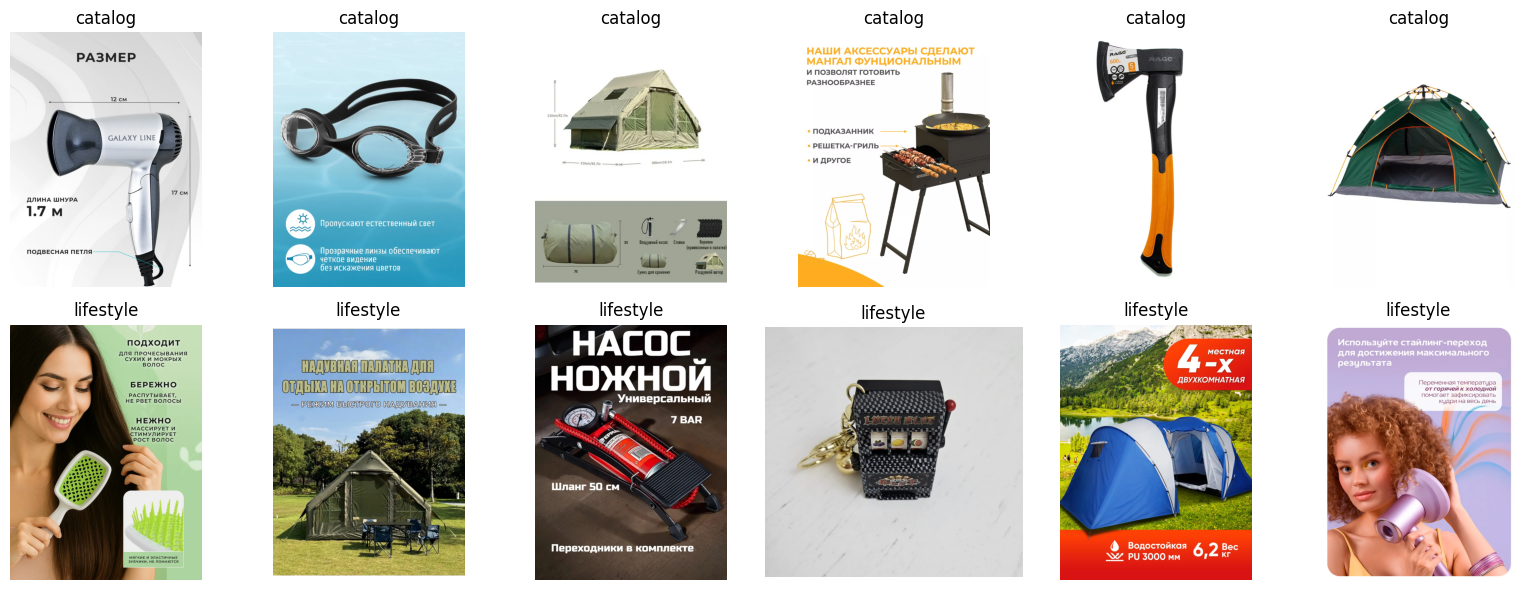

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

paths = {
    "catalog": "/content/life_or_catalog/0",
    "lifestyle": "/content/life_or_catalog/1"
}

fig, axes = plt.subplots(2, 6, figsize=(16, 6))

for row, (class_name, folder_path) in enumerate(paths.items()):
    images = [os.path.join(folder_path, f) for f in os.listdir(folder_path)[:6]]

    for col, img_path in enumerate(images):
        img = Image.open(img_path)
        axes[row, col].imshow(img)
        axes[row, col].set_title(class_name, fontsize=12)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Загрузка модели

Загрузим `Qwen/Qwen2.5-VL-3B-Instruct` и `AutoProcessor`.

In [ ]:
!pip -q install "transformers>=4.51.3" accelerate


In [ ]:
# ==== Импорты ====
import os, glob, re, json, torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report
from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration

# ==== Модель ====
MODEL_ID = "Qwen/Qwen2.5-VL-3B-Instruct"
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16 if (device == "cuda" and torch.cuda.is_bf16_supported()) else (torch.float16 if device=="cuda" else torch.float32)

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    MODEL_ID, device_map="auto" if device=="cuda" else None, torch_dtype=dtype
).eval()
processor = AutoProcessor.from_pretrained(MODEL_ID)

`torch_dtype` is deprecated! Use `dtype` instead!
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

### Получение предсказания

Напишем простой промт для классификации и код для получения предсказаний:

In [ ]:
import re
import torch
from PIL import Image

CLASSES = ["catalog", "lifestyle"]  # 0 1

PROMPT = """
Ты — классификатор изображений.
Выбери 0, если товар на однородном фоне (белый, серый) без людей и предметов.
Выбери 1, если товар на столе, в руках, на траве или в интерьере.
Ответь СТРОГО одним числом: 0 или 1.
""".strip()

_digit01 = re.compile(r'\b([01])\b')

def _first_param_device(m):
    return next(iter(m.parameters())).device

def predict_one_image_path(image_path: str):
    img = Image.open(image_path).convert("RGB")
    img = img.copy()
    img.thumbnail((640, 640))

    messages = [{
        "role": "user",
        "content": [
            {"type": "image", "image": img},
            {"type": "text", "text": PROMPT},
        ],
    }]

    prompt = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[prompt], images=[img], return_tensors="pt")
    dev = _first_param_device(model)
    inputs = {k: (v.to(dev) if hasattr(v, "to") else v) for k, v in inputs.items()}

    with torch.no_grad():
        out_ids = model.generate(**inputs, max_new_tokens=256, do_sample=False)
    input_len = inputs["input_ids"].shape[1]
    gen_ids = out_ids[:, input_len:]
    gen_text = processor.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()

    m = _digit01.search(gen_text)
    if not m:
        return {"class_id": 0, "class_name": CLASSES[0], "raw": gen_text}

    cid = int(m.group(1))
    return {"class_id": cid, "class_name": CLASSES[cid], "raw": gen_text}


IMAGE_PATH = "/content/life_or_catalog/1/1.webp"
res = predict_one_image_path(IMAGE_PATH)
print(f"pred {res['class_id']} {res['class_name']}")

pred 0 catalog


Мы получили предсказание класса `0` хотя наше изображение класса `1`. Давайте посмотрим, что это за карточка:

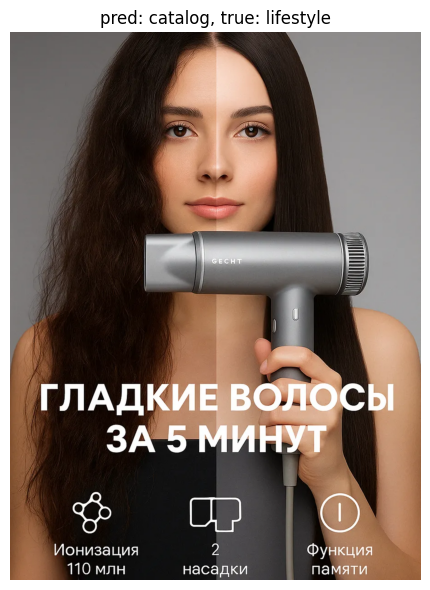

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

pred_name = CLASSES[res["class_id"]]
true_label = 1
true_name = CLASSES[true_label] if true_label is not None else None

img = Image.open(IMAGE_PATH).convert("RGB")

plt.figure(figsize=(6,6))
plt.imshow(img)
title = f"pred: {pred_name}" + (f", true: {true_name}" if true_name is not None else "")
plt.title(title)
plt.axis("off")
plt.tight_layout()
plt.show()


Видно, что модель ошиблась и здесь даже не пограничный случай, а весьма явный класс `1`. Это важный момент, который всегда будет при решении задач с VLM - промт играет решающую роль. Помимо промта нас еще будет интересовать формат вывода, но об этом позже.

In [ ]:
res.keys()

dict_keys(['class_id', 'class_name', 'raw'])

## Влияние промта

Формулировка запроса решает многое. Существует большое количество материалов по поводу того как составлять "правильные" промты, например [тут](https://www.promptingguide.ai/ru/introduction/basics). Рекомендую пользоваться простой формулой:

 **ПРОМТ=РОЛЬ+ЗАДАЧА+КОНТЕКСТ+ФОРМАТ ВЫВОДА**



* **РОЛЬ** - кем является модель и какую функцию выполняет.
* **ЗАДАЧА** - опишите одно конкретное действие (что нужно сделать?)
* **КОНТЕКСТ** - добавьте деталей. Это самое широкое поле, можно добавить правил, условий, примеров. Как добавлять примеры для VLM: просто текстом описать изображение и к какому классу оно относится.
* **ФОРМАТ ВЫВОДА** - фиксируем строгую форму ответа

Устанавливайте правило для неуверенности, для избегания галлюцинаций оставляйте пространство модели ответить "я не знаю".

Лайфхак: модели сами отличну пишут промты. Даже для изображений можно загрузить пару примеров и получить промт для классификации. Проверим более детальный промт:

In [ ]:
PROMPT = """
Ты — классификатор изображений карточек маркетплейса. На вход тебе поступает изображение товара. Твоя задача — выбрать ровно ОДИН класс:

0 — catalog: товар изолирован на однородном/градиентном фоне (белый, серый, пастельный), без реальной среды. Нет людей, рук, пола, стола, травы, мебели и т.п. Допустимы графические элементы (текст, бейджи, иконки).

1 — lifestyle: товар показан в реальной среде — на столе, полотенце, траве, в интерьере, или используется человеком (руки, лицо, часть тела). Даже если есть текст/бейджи, если есть реальная поверхность или человек — это 1.

Правила:
- Если видны люди/руки/части тела → 1.
- Если видна реальная поверхность (стол, пол, ткань, трава, вода, небо, мебель) → 1.
- Если фон — чистый градиент/белый/серый, и нет ничего кроме товара + графики → 0.
- Графика (текст, иконки, рамки) не меняет класс — только если есть реальный контекст.

Пример 1:
Изображение: расчёска на белом фоне с текстом "новинка".
Класс: 0

Пример 2:
Изображение: женщина держит сковородку.
Класс: 1

Пример 3:
Изображение: кружка на деревянном столе с цветами.
Класс: 1

Пример 4:
Изображение: телефон на сером градиенте с иконками размеров.
Класс: 0
Ответь СТРОГО одним числом: 0 или 1.
""".strip()

IMAGE_PATH = "/content/life_or_catalog/1/1.webp"
res = predict_one_image_path(IMAGE_PATH)
print(f"pred {res['class_id']} {res['class_name']}")

pred 1 lifestyle


Теперь предсказание верное, хоть наш первый промт тоде соответствовал формуле, но видимо не хватило контекста. Чем больше модель тем более сложный промт она сможет воспринимать и чем меньше модель тем более компактный и строгий он должен быть.

## Формат вывода

Гибкость вывода это ключевая особенность и преимущество VLM моделей. Модель может возвращать информацию в разных форматах что определяет ее применимость в реальных задачах.

* **Неструктурированный вывод**

Текстовое описание это свободная форма ответа. Модель генерирует развернутое описание содержимого изображения. Такой формат полезен для визуального анализа и понимания логики модели, но не подходит для автоматической обработки в пайплайне.

Перечисление объектов это частично структурированный формат. Модель составляет список основных объектов которые она видит. Это полезно для быстрого анализа содержания, но также требует дополнительной обработки.

* **Структурированный вывод**

Строгий формат ответа одним словом или числом идеален для задач классификации. Модель возвращает только метку класса что позволяет легко интегрировать ее в автоматизированные системы. Такой подход минимизирует ошибки парсинга.

Ответ в формате JSON это наиболее мощный и гибкий вариант структурированного вывода. Модель возвращает данные в структурированном виде с четкими полями. Это позволяет передавать не только класс но и дополнительную информацию такую как уверенность модели координаты объектов или поясняющие комментарии.

*Строго говоря не каждая модель может генерировать structed output, некоторые используют парсер поверх текста, например наша модель не может генерировать, но мы можем используя разные инструменты парсинга собирать "честный" json.*

Вывод одного числа мы уже тестировали, попробуем получить одно слово, например товар на изображении:

In [ ]:
PROMPT = """
Какой товар находится на изображении?
Ответь одним словом.
""".strip()

IMAGE_PATH = "/content/life_or_catalog/1/1.webp"
res = predict_one_image_path(IMAGE_PATH)
print(f"pred: {res['raw']}")

pred: Фен


Работает. Теперь попробуем посмотреть, что вообще модель может извлечь из изображения:

In [ ]:
PROMPT = """
Опиши подробно что ты видишь на этом изображении.
""".strip()

IMAGE_PATH = "/content/life_or_catalog/1/1.webp"
res = predict_one_image_path(IMAGE_PATH)
print(f"pred: \n{res['raw']}")

pred: 
На изображении изображен человек с длинными, темными волосами, держащий в руке фен. В верхней части изображения написано на русском языке: "ГЛАДКИЕ ВОЛОСЫ ЗА 5 МИНУТ". Нижняя часть изображения содержит три значка:

1. Слева находится значок с изображением ионов, сопровождаемый текстом "Ионизация 110 млн".
2. В центре находится значок с изображением насадки, сопровождаемый текстом "2 насадки".
3. Справа находится значок с изображением часов, сопровождаемый текстом "Функция памяти".

Эти элементы указывают на функции и преимущества фена, которые позволяют быстро и качественно укладывать волосы.


Как видим детализация довольно высокого уровня. Модель хорошо распознала текст и описала изображение. Попробуем получить json формат:

In [ ]:
PROMPT = """
Верни результат строго в формате JSON без пояснений без подсказок без обрамления в код
Если чего то не знаешь поставь в поле null
Структура
{
  "human": "<есть присутствие человека на изображении или нет. 1 - есть, 0 - нет.>",
  "text": "<полный распознанный текст в естественном порядке>",
  "language": "<основной язык или unknown>",
  "category": <категория товара, одно слово>,
}
""".strip()

IMAGE_PATH = "/content/life_or_catalog/1/1.webp"
res = predict_one_image_path(IMAGE_PATH)
print(f"pred: \n{res['raw']}")

pred: 
```json
{
  "human": "1",
  "text": "ГЛАДКИЕ ВОЛОСЫ ЗА 5 МИНУТ Ионизация 110 млн 2 насадки Функция памяти",
  "language": "Russian",
  "category": "Hair Dryer"
}
```


Получилось, но уже стали видны нюансы, что категория была написана двумя словами и на английском, промт требует уточнений.

Попробуем решить задачу детекции и получить координаты лица человека на изображении:

In [ ]:
PROMPT = """
Верни результат строго в формате JSON без пояснений без подсказок без обрамления в код
Если чего то не знаешь поставь в поле null
Структура
{
  "human": "<есть присутствие человека на изображении или нет. 1 - есть, 0 - нет.>",
  "coords": "<координаты лици четыре числа x y w h в пикселях через пробел x и y это левый верхний угол>",
}
""".strip()

IMAGE_PATH = "/content/life_or_catalog/1/1.webp"
res = predict_one_image_path(IMAGE_PATH)
print(f"pred: \n{res['raw']}")

pred: 
```json
{
  "human": "1",
  "coords": "23,0,476,644"
}
```


Какой то результат получился, правда координаты не через пробел, а через запятую. Нарисуем, чтобы проверить на сколько они соотвествуют действительности:

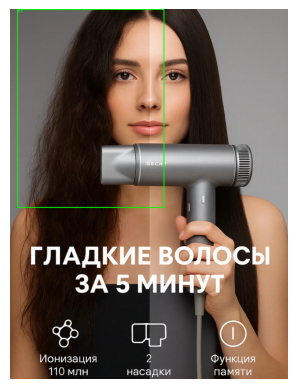

In [ ]:
import re, json
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def draw_bbox(path, coords, label=None):
    x, y, w, h = map(int, str(coords).replace(",", " ").split())
    img = Image.open(path).convert("RGB")
    d = ImageDraw.Draw(img)
    d.rectangle([x, y, x + w, y + h], outline=(0,255,0), width=3)
    if label:
        d.text((x, max(0, y - 12)), str(label), fill=(0,255,0))
    plt.imshow(img); plt.axis("off"); plt.show()

coords = json.loads(re.search(r'\{.*\}', res['raw'], flags=re.S).group(0))["coords"]
draw_bbox(IMAGE_PATH, coords, label="face")


Видим, что модель плохо справилась с этой задачей, что ожидаемо. Есть модели которые хорошо справляются с такого рода задачами, например [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO)

## Весь пайплайн

Запустим модель с подобраным промтом и оценим качество предсказания (этот блок может выполняться независимо)

In [ ]:
CLASSES = ["catalog", "lifestyle"]  # 0, 1

PROMPT = """
Ты — классификатор изображений карточек маркетплейса. На вход тебе поступает изображение товара. Твоя задача — выбрать ровно ОДИН класс:

0 — catalog: товар изолирован на однородном/градиентном фоне (белый, серый, пастельный), без реальной среды. Нет людей, рук, пола, стола, травы, мебели и т.п. Допустимы графические элементы (текст, бейджи, иконки).

1 — lifestyle: товар показан в реальной среде — на столе, полотенце, траве, в интерьере, или используется человеком (руки, лицо, часть тела). Даже если есть текст/бейджи, если есть реальная поверхность или человек — это 1.

Правила:
- Если видны люди/руки/части тела → 1.
- Если видна реальная поверхность (стол, пол, ткань, трава, вода, небо, мебель) → 1.
- Если фон — чистый градиент/белый/серый, и нет ничего кроме товара + графики → 0.
- Графика (текст, иконки, рамки) не меняет класс — только если есть реальный контекст.

Пример 1:
Изображение: расчёска на белом фоне с текстом "новинка".
Класс: 0

Пример 2:
Изображение: женщина держит сковородку.
Класс: 1

Пример 3:
Изображение: кружка на деревянном столе с цветами.
Класс: 1

Пример 4:
Изображение: телефон на сером градиенте с иконками размеров.
Класс: 0
Ответь СТРОГО одним числом: 0 или 1.
""".strip()

_digit01 = re.compile(r'\b([01])\b')

def _first_param_device(m):
    return next(iter(m.parameters())).device

def predict_class(img: Image.Image) -> dict:
    img = img.copy()
    img.thumbnail((640, 640))

    messages = [{
        "role": "user",
        "content": [{"type": "image", "image": img}, {"type": "text", "text": PROMPT}],
    }]

    prompt = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[prompt], images=[img], return_tensors="pt")

    dev = _first_param_device(model)
    inputs = {k: (v.to(dev) if hasattr(v, "to") else v) for k, v in inputs.items()}

    with torch.no_grad():
        out_ids = model.generate(**inputs, max_new_tokens=16, do_sample=False)

    input_len = inputs["input_ids"].shape[1]
    gen_ids = out_ids[:, input_len:]
    gen_text = processor.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()

    m = _digit01.search(gen_text)
    if not m:
        return {"class_id": 0, "class_name": CLASSES[0], "raw": gen_text}
    cid = int(m.group(1))
    return {"class_id": cid, "class_name": CLASSES[cid], "raw": gen_text}

ROOT = "/content/life_or_catalog"  # структура: /0 и /1
image_paths, y_true = [], []
for lbl in ("1", "0"):
    folder = os.path.join(ROOT, lbl)
    if not os.path.isdir(folder): continue
    files = []
    for ext in ("*.jpg","*.jpeg","*.png","*.webp","*.bmp","*.JPG","*.JPEG","*.PNG","*.WEBP","*.BMP"):
        files.extend(glob.glob(os.path.join(folder, ext)))
    files.sort()
    image_paths += files
    y_true += [int(lbl)] * len(files)

print(f"Найдено изображений: {len(image_paths)}")

Найдено изображений: 50


In [ ]:
y_pred, raws = [], []
for i, (path, true_lbl) in enumerate(zip(image_paths, y_true), 1):
    try:
        img = Image.open(path).convert("RGB")
        pred = predict_class(img)
        y_pred.append(pred["class_id"]); raws.append(pred["raw"])
        mark = "✅" if pred["class_id"] == true_lbl else "❌"
        print(f"{mark} [{i}/{len(image_paths)}] {os.path.basename(path)} | true={true_lbl} pred={pred['class_id']} ({pred['class_name']})")
    except Exception as e:
        y_pred.append(0); raws.append(f"ERROR: {e}")
        print(f"⚠️ [{i}/{len(image_paths)}] {os.path.basename(path)} | ошибка: {e}")

✅ [1/50] 1.webp | true=1 pred=1 (lifestyle)
✅ [2/50] 12457.webp | true=1 pred=1 (lifestyle)
✅ [3/50] 1512.webp | true=1 pred=1 (lifestyle)
✅ [4/50] 18.webp | true=1 pred=1 (lifestyle)
✅ [5/50] 2.webp | true=1 pred=1 (lifestyle)
✅ [6/50] 412.webp | true=1 pred=1 (lifestyle)
❌ [7/50] 4235.webp | true=1 pred=0 (catalog)
✅ [8/50] 4325.webp | true=1 pred=1 (lifestyle)
✅ [9/50] 4532.webp | true=1 pred=1 (lifestyle)
✅ [10/50] 5.webp | true=1 pred=1 (lifestyle)
✅ [11/50] 512566.webp | true=1 pred=1 (lifestyle)
✅ [12/50] 523.webp | true=1 pred=1 (lifestyle)
✅ [13/50] 5231.webp | true=1 pred=1 (lifestyle)
✅ [14/50] 523112.webp | true=1 pred=1 (lifestyle)
✅ [15/50] 5236.webp | true=1 pred=1 (lifestyle)
✅ [16/50] 531.webp | true=1 pred=1 (lifestyle)
✅ [17/50] 5345.webp | true=1 pred=1 (lifestyle)
❌ [18/50] 54352.webp | true=1 pred=0 (catalog)
✅ [19/50] 643.webp | true=1 pred=1 (lifestyle)
✅ [20/50] 6435.webp | true=1 pred=1 (lifestyle)
✅ [21/50] 7457.webp | true=1 pred=1 (lifestyle)
✅ [22/50] 754.

Видно, что почти все объекты классифицированы верно, посчитаем метрики и посмотрим на объекты с ошибкой:


Classification report:
               precision    recall  f1-score   support

  catalog (0)      0.923     0.960     0.941        25
lifestyle (1)      0.958     0.920     0.939        25

     accuracy                          0.940        50
    macro avg      0.941     0.940     0.940        50
 weighted avg      0.941     0.940     0.940        50

Balanced accuracy: 0.9400


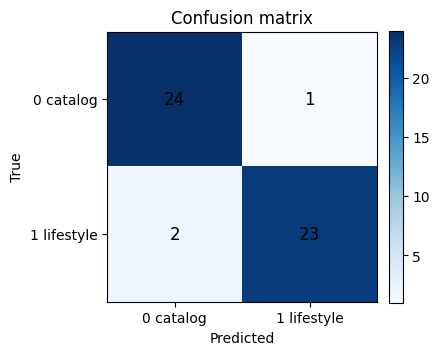


Ошибки (3):
  4235.webp: true=1, pred=0
  54352.webp: true=1, pred=0
  1124.webp: true=0, pred=1


In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
bacc = balanced_accuracy_score(y_true, y_pred)

print("\nClassification report:")
print(classification_report(y_true, y_pred, digits=3, target_names=["catalog (0)","lifestyle (1)"]))
print(f"Balanced accuracy: {bacc:.4f}")

fig, ax = plt.subplots(figsize=(4.5, 4.5))
im = ax.imshow(cm, cmap="Blues")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center", fontsize=12)
ax.set_title("Confusion matrix")
ax.set_xticks([0,1]); ax.set_xticklabels(["0 catalog","1 lifestyle"])
ax.set_yticks([0,1]); ax.set_yticklabels(["0 catalog","1 lifestyle"])
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

errs = [(os.path.basename(p), t, p_) for p, t, p_ in zip(image_paths, y_true, y_pred) if t != p_]
if errs:
    print(f"\nОшибки ({len(errs)}):")
    for name, t, p_ in errs[:10]:
        print(f"  {name}: true={t}, pred={p_}")


Отобразим эти объекты:

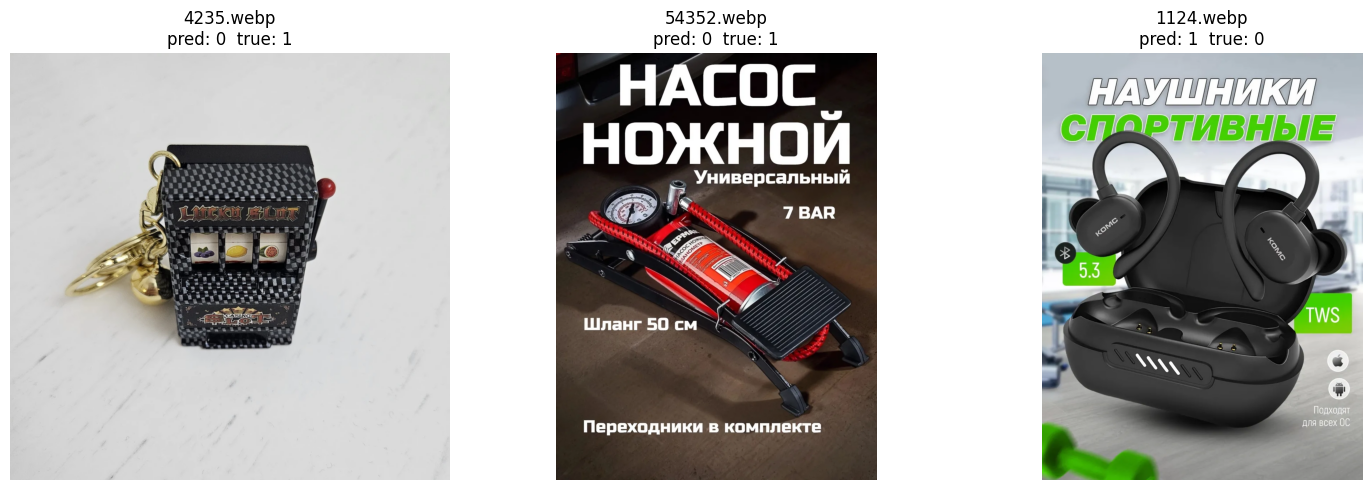

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

items = [
    ("/content/life_or_catalog/1", "4235.webp", 1, 0),
    ("/content/life_or_catalog/1", "54352.webp", 1, 0),
    ("/content/life_or_catalog/0", "1124.webp", 0, 1),
]

fig, axes = plt.subplots(1, len(items), figsize=(5*len(items), 5))
axes = [axes] if len(items) == 1 else axes

for ax, (folder, name, true, pred) in zip(axes, items):
    img = Image.open(os.path.join(folder, name)).convert("RGB")
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"{name}\npred: {pred}  true: {true}", fontsize=12)

plt.tight_layout()
plt.show()


Видно, что `брелок-автомат` действительно похож больше на класс "каталог", а `наушники` больше подходит на класс "лайфстайл" из за фона, а вот с насосом действительно ошибка. Таким образом мы можем искать ошибки в разметке или делать доп проверки.

# Заключение и выводы

В этом блокноте мы рассмотрели практическое применение VLM модели Qwen для решения реальной задачи классификации изображений маркетплейса. Мы успешно разделили фотографии товаров на две категории каталожные и лайфстайл без предварительного обучения модели на наших данных.

Проверили, что VLM модели эффективно справляются с задачами где требуется семантическое понимание изображения. Модель смогла распознать контекст сцены и различить нейтральный фон студии и естественную обстановку.

Основные преимущества подхода:
* Нулевое обучение модель не требует тонкой настройки
* Гибкость легко изменить промт для новых классов
* Интерпретируемость можно получить пояснения к классификации
* Быстрое прототипирование можно быстро тестировать гипотезы

Ограничения подхода:
* Скорость обработки ниже чем у специализированных CNN моделей
* Зависимость от качества промта
* Стоимость вычислений для больших датасетов

VLM модели открывают новые возможности для компьютерного зрения. Они особенно полезны для задач где сложно собрать большой размеченный датасет или где требуется понимание сложных визуальных концепций. Рассмотренный подход можно адаптировать для других задач классификации объектов или анализа сцен.
